In [1]:
import sys, os, re, jax
sys.path.append(os.path.abspath("./../../feedback-grape"))
sys.path.append(os.path.abspath("./../../"))
sys.path.append(os.path.abspath("./../"))

from matplotlib import pyplot as plt
import numpy as np

from plot_helpers import (
    open_from_dir,
    plot_runs,
    plot_runs_1D,
    plot_grid,
    grid_grouped_params,
    select_best_runs,
    extract_time_constants,
    sort_by,
    _labels_from_params,
)

In [2]:
dir_ = "./10_results"
favour_oscillations = lambda fidelities: np.mean([np.max(fidelities[i:i+4]) for i in range(0, len(fidelities), 4)])
fidelities_mat, params_grouped, params_each = open_from_dir(dir_ + "/eval", exclude=r".*s=4.*") # Exclude s=4, which shows oscillations
fidelities_best_mat, params_grouped_best, params_each_best = select_best_runs(fidelities_mat, params_each)#, objective_fun=favour_oscillations)

Opening files...


100%|██████████| 720/720 [00:00<00:00, 1875.12it/s]

Done.


Text(0.5, 1.0, 'Fidelity over Time for all runs')

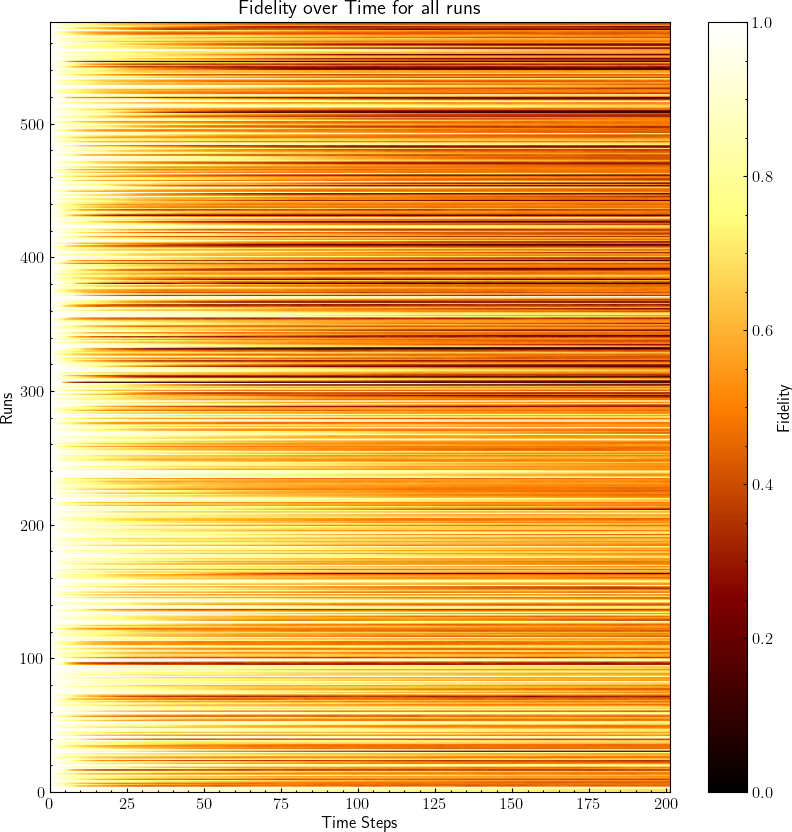

In [3]:
fig, ax, im = plot_runs(
    fidelities_mat,
    params_grouped,
    sort_by="s",
    show_labels=False,
    figsize=(10,10),
)
ax.set_title("Fidelity over Time for all runs")

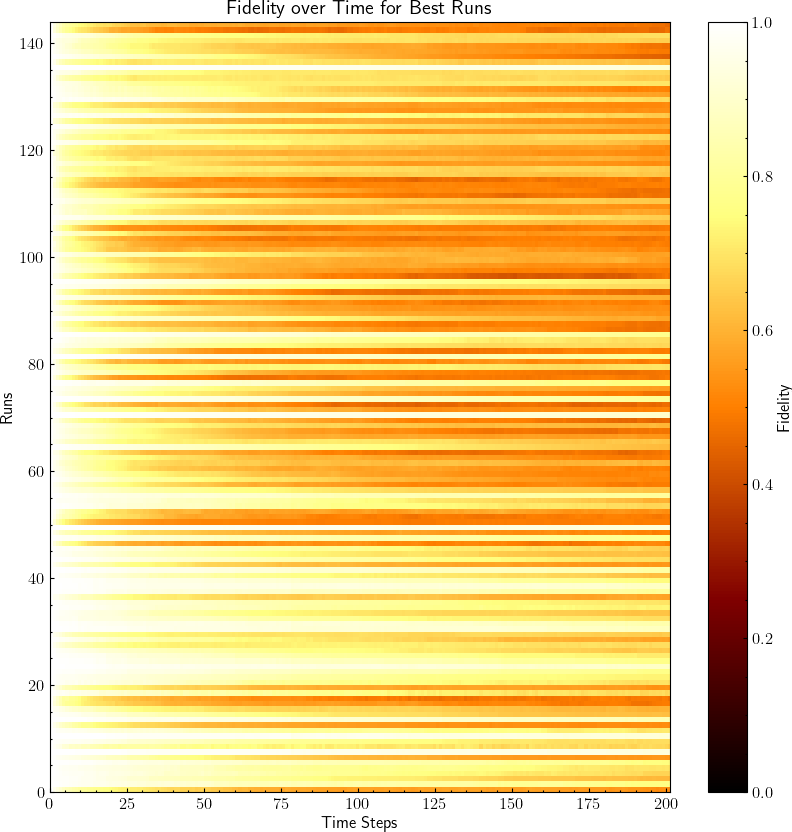

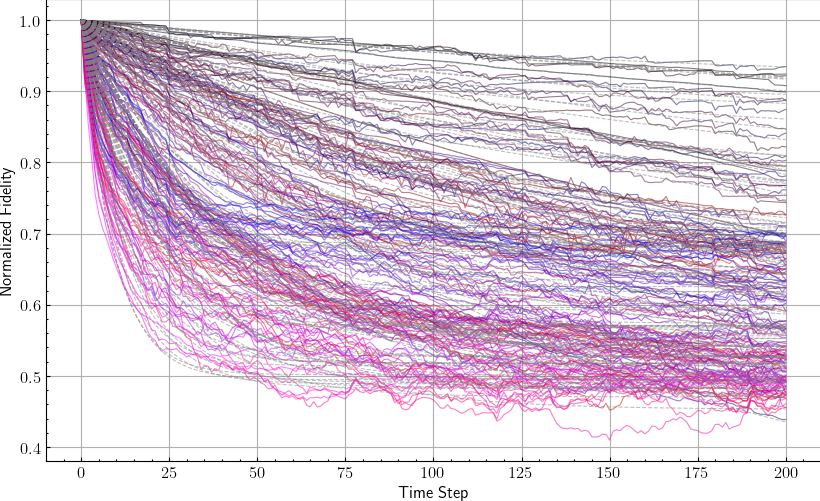

In [4]:
fig, ax, im = plot_runs(
    fidelities_best_mat,
    params_grouped_best,
    sort_by="s",
    show_labels=False,
    figsize=(10,10),
)
ax.set_title("Fidelity over Time for Best Runs")

N = 20  # Number of runs to plot with exponential fits

exp_fits = extract_time_constants(fidelities_best_mat)

idx = np.arange(fidelities_best_mat.shape[0]) #np.random.choice(fidelities_best_mat.shape[0], N, replace=False)
fig, ax = plot_runs_1D(
    fidelities_best_mat[idx],
    {param: [params_grouped_best[param][i] for i in idx] for param in params_grouped_best},
    figsize=(10,6),
)

for i in idx:
    a = exp_fits[0][i]
    tau = exp_fits[1][i]
    time_steps = np.arange(fidelities_best_mat.shape[1])
    fit = a * np.exp(-time_steps / tau) + (1 - a)
    ax.plot(time_steps, fit, "--", color="gray", alpha=0.5)

Opening files...


100%|██████████| 173/173 [00:00<00:00, 1563.74it/s]

Done.


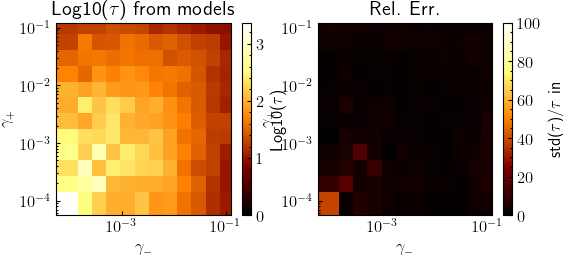

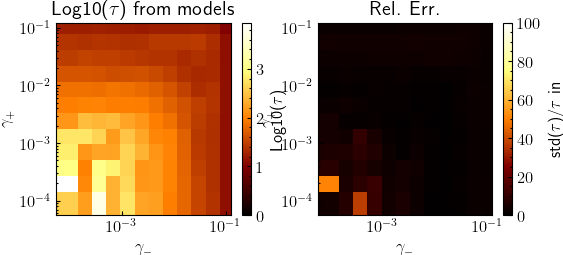

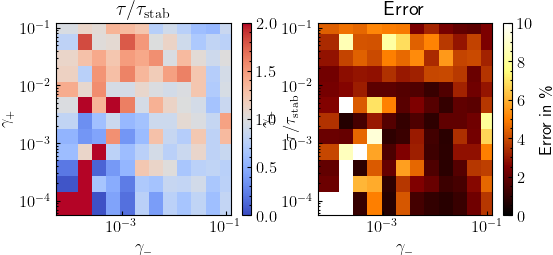

In [5]:
def plot_params2D(param_name, param_values, param_errors, params_grouped):
    gamma_m_values, gamma_p_values, param_grid = grid_grouped_params(param_values, params_grouped, "gammam", "gammap")
    _, _, param_err_grid = grid_grouped_params(param_errors/param_values, params_grouped, "gammam", "gammap")

    # Plot parameter and error heatmaps
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6.1811,2.5))
    im = ax1.pcolormesh(
        gamma_m_values,
        gamma_p_values,
        np.log10(param_grid),
        cmap='afmhot',
        vmin = 0,
    )
    ax1.set_xlabel("$\\gamma_-$")
    ax1.set_ylabel("$\\gamma_+$")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_title(f"Log10(${param_name}$) from models")
    fig.colorbar(im, ax=ax1, label=f"Log10(${param_name}$)")

    im = ax2.pcolormesh(
        gamma_m_values,
        gamma_p_values,
        param_err_grid * 100,
        cmap='afmhot',
        vmin = 0,
        vmax = 100,
    )
    ax2.set_xlabel("$\\gamma_-$")
    ax2.set_ylabel("$\\gamma_+$")
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_title("Rel. Err.")
    fig.colorbar(im, ax=ax2, label=f"std(${param_name}$)/${param_name}$ in %")
    plt.show()

def compare_params2d(param_name, param_values1, param_errors1, param_values2, param_errors2, params_grouped):
    gamma_m_values, gamma_p_values, param_grid = grid_grouped_params(param_values1, params_grouped, "gammam", "gammap")
    _, _, param_err_grid = grid_grouped_params(param_errors1/param_values1, params_grouped, "gammam", "gammap")

    gamma_m_values2, gamma_p_values2, param_grid2 = grid_grouped_params(param_values2, params_grouped, "gammam", "gammap")
    _, _, param_err_grid2 = grid_grouped_params(param_errors2/param_values2, params_grouped, "gammam", "gammap")

    assert np.allclose(gamma_m_values, gamma_m_values2)
    assert np.allclose(gamma_p_values, gamma_p_values2)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6.1811,2.5))
    im = ax1.pcolormesh(
        gamma_m_values,
        gamma_p_values,
        param_grid / param_grid2,
        cmap='coolwarm',
        vmin=0,
        vmax=2,
    )
    ax1.set_xlabel("$\\gamma_-$")
    ax1.set_ylabel("$\\gamma_+$")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_title(f"${param_name}$/${param_name}_{{\\rm{{stab}}}}$")
    fig.colorbar(im, ax=ax1, label=f"${param_name}$/${param_name}_{{\\rm{{stab}}}}$")

    err_grid = param_grid / param_grid2 * np.sqrt( param_err_grid**2 + param_err_grid2**2 )
    
    im = ax2.pcolormesh(
        gamma_m_values,
        gamma_p_values,
        err_grid * 100,
        cmap='afmhot',
        vmin = 0,
        vmax = 10,
    )
    ax2.set_xlabel("$\\gamma_-$")
    ax2.set_ylabel("$\\gamma_+$")
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_title("Error")
    fig.colorbar(im, ax=ax2, label="Error in \\%%")
    plt.show()

def compare_params1d(param_name, param_values1, param_errors1, param_values2, param_errors2, params_grouped, y_max=3, columns=3):
    gamma_m_values, gamma_p_values, param_grid = grid_grouped_params(param_values1, params_grouped, "gammam", "gammap")
    _, _, param_err_grid = grid_grouped_params(param_errors1/param_values1, params_grouped, "gammam", "gammap")

    gamma_m_values2, gamma_p_values2, param_grid2 = grid_grouped_params(param_values2, params_grouped, "gammam", "gammap")
    _, _, param_err_grid2 = grid_grouped_params(param_errors2/param_values2, params_grouped, "gammam", "gammap")

    assert np.allclose(gamma_m_values, gamma_m_values2)
    assert np.allclose(gamma_p_values, gamma_p_values2)

    err_grid = param_grid / param_grid2 * np.sqrt( param_err_grid**2 + param_err_grid2**2 )

    fig, axs = plt.subplots(len(gamma_m_values)//columns, columns, figsize=(6.1811, len(gamma_m_values)*3/4/1.5), sharey=True, sharex=True)
    axs = axs.flatten()
    for i, (ax, gamma_p) in enumerate(zip(axs, gamma_p_values)):
        y = param_grid[i,:]/param_grid2[i,:]
        err = err_grid[i,:]
        mask = y < y_max*0.98

        ax.axhline(1, color="gray", ls="--")
        ax.errorbar(gamma_m_values[mask], y[mask], yerr=err[mask], fmt=".")

        #ax.annotate("$\\gamma_+ = {:.4f}$".format(gamma_p), xy=(0.5, 0.9), xycoords='axes fraction')
        # for masked data points, indicate that they are out of bounds
        for x1,y1 in zip(gamma_m_values[~mask], y[~mask]):
            ax.scatter(x1, y_max*0.95, marker="^", color="black", facecolors="none")
            ax.annotate(f"{y1:.1f}", xy=(x1, y_max*0.85), xycoords='data', color="black", ha="center", fontsize=7)

        ax.set_xscale("log")
        ax.set_title("$\\gamma_+ = {:.4f}$".format(gamma_p))

        if i % columns == 0:
            ax.set_ylabel(f"${param_name}_{{\\rm{{model}}}}$/${param_name}_{{\\rm{{stab}}}}$")
        if i >= len(gamma_m_values) - columns:
            ax.set_xlabel("$\\gamma_-$")


    axs[0].set_ylim(ymin=0, ymax=y_max)
    fig.tight_layout()
    plt.show()

fidelities_mat_stab, params_grouped_stab, params_each_stab = open_from_dir(dir_ + "/custom/Stabilizer code")
fidelities_mat_stab, params_grouped_stab, params_each_stab = sort_by(fidelities_mat_stab, params_each_stab, params_each_best, ignored_keys=["s", "l", "rhoe", "Nmeas"], do_remove_missing=True) # to have same order as before. Ignore params not needed for stabilizer code. Also ignore "rhoe" because of earlier bug in saving/loading.

exp_fits_stab = extract_time_constants(fidelities_mat_stab)

plot_params2D("\\tau", exp_fits[1], exp_fits[3], params_grouped_best)
plot_params2D("\\tau", exp_fits_stab[1], exp_fits_stab[3], params_grouped_stab)
compare_params2d("\\tau",exp_fits[1],exp_fits[3],exp_fits_stab[1],exp_fits_stab[3],params_grouped_best)
#compare_params1d("\\tau",exp_fits[1],exp_fits[3],exp_fits_stab[1],exp_fits_stab[3],params_grouped_best)

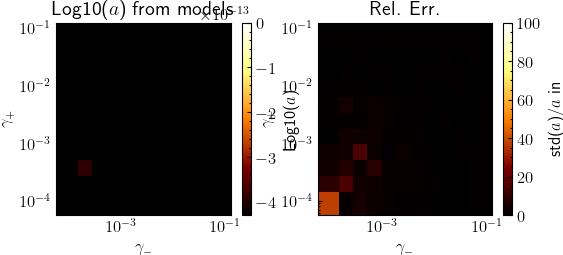

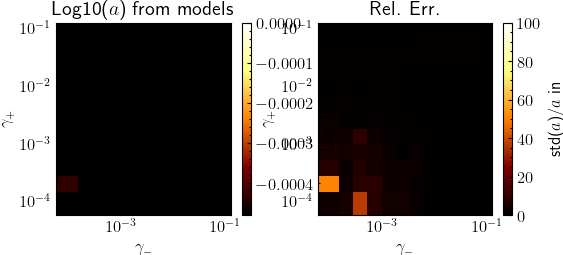

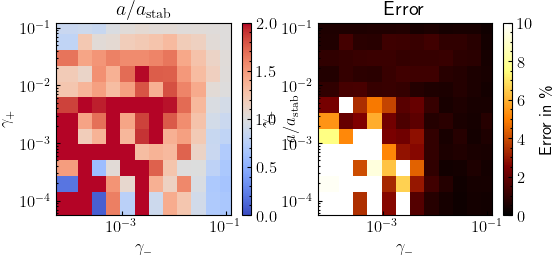

In [6]:
plot_params2D("a", exp_fits[0], exp_fits[2], params_grouped_best)
plot_params2D("a", exp_fits_stab[0], exp_fits_stab[2], params_grouped_stab)
compare_params2d("a",exp_fits[0],exp_fits[2],exp_fits_stab[0],exp_fits_stab[2],params_grouped_best)
#compare_params1d("a",exp_fits[0],exp_fits[2],exp_fits_stab[0],exp_fits_stab[2],params_grouped_best)

Opening files...


100%|██████████| 144/144 [00:00<00:00, 4337.07it/s]

Done.


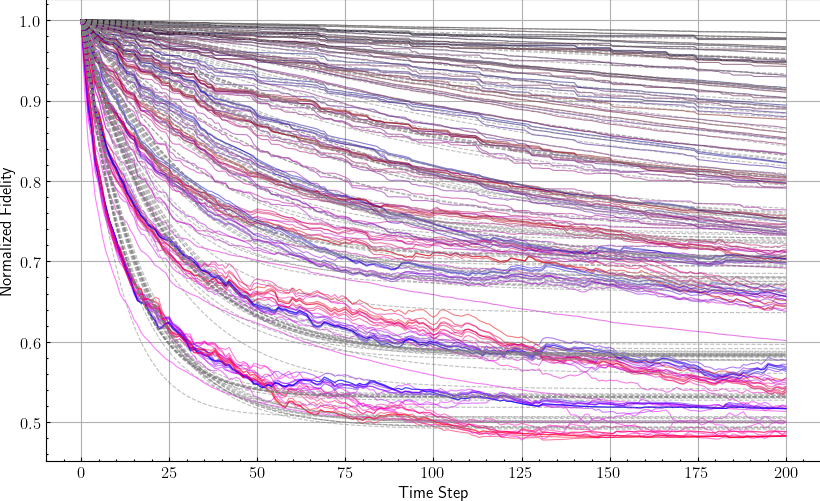

In [7]:
fidelities_mat_base, params_grouped_base, params_each_base = open_from_dir(dir_ + "/baseline")

idx = np.arange(fidelities_mat_stab.shape[0])
fig, ax = plot_runs_1D(
    fidelities_mat_stab[idx],
    {param: [params_grouped_stab[param][i] for i in idx] for param in params_grouped_stab},
    figsize=(10,6),
)

for i in idx:
    a = exp_fits_stab[0][i]
    tau = exp_fits_stab[1][i]
    time_steps = np.arange(fidelities_mat_stab.shape[1])
    fit = a * np.exp(-time_steps / tau) + (1 - a)
    ax.plot(time_steps, fit, "--", color="gray", alpha=0.5)

In [8]:
"""
fidelities_diff = fidelities_best_mat - fidelities_mat_stab

labels = _labels_from_params(params_grouped_best, show_s=True)

idx = np.argsort(params_grouped_best["s"])
labels = [labels[i] for i in idx]
fidelities_diff = fidelities_diff[idx, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.1811*2, 20))
im1 = ax1.imshow(
    fidelities_diff, aspect='auto', origin='lower', 
    extent=[0, fidelities_diff.shape[1], 0, fidelities_diff.shape[0]],
    vmin=0, vmax=None,
    cmap='afmhot',
    interpolation=None,
)
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Runs")
fig.colorbar(im1, ax=ax1, label="Difference")
ax1.set_yticks(np.arange(len(labels)) + 0.5)
ax1.set_yticklabels(labels)
ax1.set_title("Model minus stabilizer fidelities")

im2 = ax2.imshow(
    fidelities_best_mat[idx, :], aspect='auto', origin='lower', 
    extent=[0, fidelities_best_mat.shape[1], 0, fidelities_best_mat.shape[0]],
    vmin=0, vmax=None,
    cmap='afmhot',
    interpolation=None,
)
ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Runs")
fig.colorbar(im2, ax=ax2, label="Difference")
ax2.set_yticks(np.arange(len(labels)) + 0.5)
ax2.set_title("Model fidelities")
"""

'\nfidelities_diff = fidelities_best_mat - fidelities_mat_stab\n\nlabels = _labels_from_params(params_grouped_best, show_s=True)\n\nidx = np.argsort(params_grouped_best["s"])\nlabels = [labels[i] for i in idx]\nfidelities_diff = fidelities_diff[idx, :]\n\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.1811*2, 20))\nim1 = ax1.imshow(\n    fidelities_diff, aspect=\'auto\', origin=\'lower\', \n    extent=[0, fidelities_diff.shape[1], 0, fidelities_diff.shape[0]],\n    vmin=0, vmax=None,\n    cmap=\'afmhot\',\n    interpolation=None,\n)\nax1.set_xlabel("Time Steps")\nax1.set_ylabel("Runs")\nfig.colorbar(im1, ax=ax1, label="Difference")\nax1.set_yticks(np.arange(len(labels)) + 0.5)\nax1.set_yticklabels(labels)\nax1.set_title("Model minus stabilizer fidelities")\n\nim2 = ax2.imshow(\n    fidelities_best_mat[idx, :], aspect=\'auto\', origin=\'lower\', \n    extent=[0, fidelities_best_mat.shape[1], 0, fidelities_best_mat.shape[0]],\n    vmin=0, vmax=None,\n    cmap=\'afmhot\',\n    interpolat

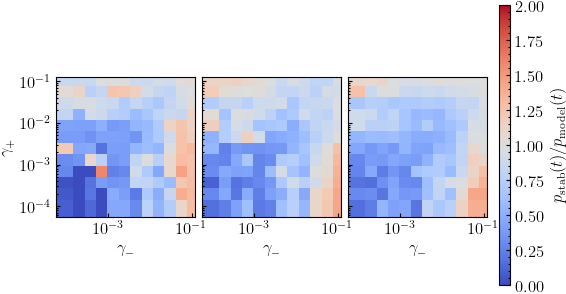

In [9]:
analyse_timesteps = [2,20,200]#[10, 50, 200]

def plot_single_timestep(i, t, ax, params_grouped):
    p1 = 1 - fidelities_best_mat[:, t] # Error probabilities at time t for model
    p2 = 1 - fidelities_mat_stab[:, t] # Error probabilities at time t for stabilizer code

    gamma_m_values, gamma_p_values, p1_grid = grid_grouped_params(p1, params_grouped, "gammam", "gammap")
    gamma_m_values2, gamma_p_values2, p2_grid = grid_grouped_params(p2, params_grouped, "gammam", "gammap")
    assert np.allclose(gamma_m_values, gamma_m_values2)
    assert np.allclose(gamma_p_values, gamma_p_values2)

    im = ax.pcolormesh(
        gamma_m_values,
        gamma_p_values,
        p2_grid / p1_grid,
        cmap='coolwarm',
        vmin=0.0,
        vmax=+2.0,
    )
    ax.set_xlabel("$\\gamma_-$")
    if i == 0:
        ax.set_ylabel("$\\gamma_+$")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect('equal')

    return im

fig, axs = plt.subplots(1, len(analyse_timesteps), figsize=(6.1811 - 1.2/2.54, 4), sharey=True)
for i, t in enumerate(analyse_timesteps):
    im = plot_single_timestep(i, t, axs[i], params_grouped_best)

plt.subplots_adjust(wspace=0.05, hspace=0, right=0.88)

# colorbar on the right
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label=f"$p_{{\\rm{{stab}}}}(t)$/$p_{{\\rm{{model}}}}(t)$")
fig.savefig(f"{dir_}/comparison_stabilizer_vs_model.svg")

plt.show()